Total Hamiltonian H_vac:
 [[0.        +0.j 1.57079633+0.j 1.57079633+0.j 0.        +0.j
  1.57079633+0.j 0.        +0.j 0.        +0.j 0.        +0.j
  1.57079633+0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [1.57079633+0.j 0.        +0.j 0.        +0.j 1.57079633+0.j
  0.        +0.j 1.57079633+0.j 0.        +0.j 0.        +0.j
  0.        +0.j 1.57079633+0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [1.57079633+0.j 0.        +0.j 0.        +0.j 1.57079633+0.j
  0.        +0.j 0.        +0.j 1.57079633+0.j 0.        +0.j
  0.        +0.j 0.        +0.j 1.57079633+0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 1.57079633+0.j 1.57079633+0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 1.57079633+0.j
  0.        +0.j 0.        +0.j 0.        +0.j 1.57079633+0.j
  0.        +0.j 0.        +0.j 0.       

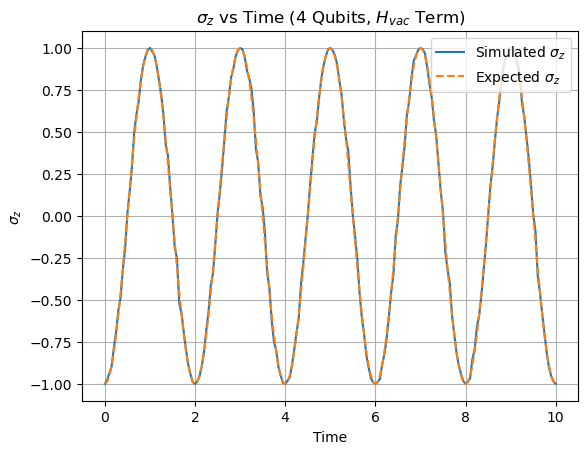

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import Aer, transpile, assemble, execute
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import Pauli, Statevector, Operator

# Constants and simulation parameters
N_sites = 4  # Number of qubits
delta_m_squared = np.pi
omega_a = np.full(N_sites // 2, delta_m_squared)
omega_b = np.full(N_sites // 2, delta_m_squared)
omega = np.concatenate((omega_a, omega_b))
B = [1, 0, 0]
shots = 1024
backend = AerSimulator(method = 'automatic')
tolerance = 0.1 
τ = 0.05  # Time step
ttotal = 10  # Total time
times = np.arange(0, ttotal + τ, τ)  # Define time steps
# Initialize the Hamiltonian
H_vac = np.zeros((2**N_sites, 2**N_sites), dtype=complex)

# Define the Hamiltonian H for N qubits including all components [x, y, z]
for i in range(N_sites-1):
    for j in range(i + 1, N_sites):
        # H_vac terms for site i
        Xi = (omega[i] / 2) * B[0] * Pauli(f'{"I"*i}X{"I"*(N_sites-i-1)}').to_matrix()
        Yi = (omega[i] / 2) * B[1] * Pauli(f'{"I"*i}Y{"I"*(N_sites-i-1)}').to_matrix()
        Zi = (omega[i] / 2) * B[2] * Pauli(f'{"I"*i}Z{"I"*(N_sites-i-1)}').to_matrix()
        H_vac += (1/(N_sites-1)) * (Xi + Yi + Zi)
        
        # H_vac terms for site j
        Xj = (omega[j] / 2) * B[0] * Pauli(f'{"I"*j}X{"I"*(N_sites-j-1)}').to_matrix()
        Yj = (omega[j] / 2) * B[1] * Pauli(f'{"I"*j}Y{"I"*(N_sites-j-1)}').to_matrix()
        Zj = (omega[j] / 2) * B[2] * Pauli(f'{"I"*j}Z{"I"*(N_sites-j-1)}').to_matrix()
        H_vac += (1/(N_sites-1))* (Xj + Yj + Zj)

# Print the total Hamiltonian for verification
print("Total Hamiltonian H_vac:\n", H_vac)


def evolve_and_measure_circuit(time, H_vac):
    U = Operator(expm(-1j * H_vac * time))
    qc = QuantumCircuit(N_sites, 1) # Measure only the fisrt qubit
    half_N_sites = N_sites // 2  # Calculate the size of the first half of the chain
    qc.x(range(half_N_sites))  # Apply X gate to the  first half of the qubits i.e. first and second qubits to create |1100> state
    qc.unitary(U, range(N_sites), label="exp(-iHt)")
    qc.measure(0, 0)  # Measure only the fisrt qubit
    return qc

sigma_z_values = []
expected_sz_array = []

for t in times:
    expected_sz = []
    for omega_i in omega:
        expected_sz.append(-1 * np.cos(omega_i * t))
    expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)
    
    qc = evolve_and_measure_circuit(t, H_vac)
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    
    # Calculate expectation value of sigma_z for the first qubit
    sigma_z = 0
    for outcome, count in counts.items():
        if outcome[0] == '0':
            sigma_z += count / shots
        else:
            sigma_z -= count / shots
    sigma_z_values.append(sigma_z)
    
    
# Verify the condition
assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"

# Plot the survival probability at site 1 against time
plt.plot(times, sigma_z_values, label='Simulated $\sigma_z$')
plt.plot(times, expected_sz_array, label='Expected $\sigma_z$', linestyle='--')
plt.xlabel('Time')
plt.ylabel('$\sigma_z$')
plt.title(f'$\sigma_z$ vs Time ({N_sites} Qubits, $H_{{vac}}$ Term)')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


